### Least Squares

##### Standard Problem:
$$
\begin{aligned}
\min_{x} \quad & \lVert x \rVert_2^2 \\
\textrm{s.t.} \quad & Ax = b
\end{aligned}
$$

##### Lagrangian:
$$
\begin{aligned}
\mathcal{L}(x, \lambda) = \min_{x} \max_{\lambda} \quad & x^{\top}x + \lambda^{\top} (Ax - b)
\end{aligned}
$$

##### Analytical Solution
$$
\begin{aligned}
\frac{\partial}{\partial \lambda} \rightarrow & Ax^\ast = b & (1) \\
\frac{\partial}{\partial x} \rightarrow & 2x^\ast + A^\top \lambda^\ast = 0 & \\
& x^\ast = - \frac{1}{2}A^\top\lambda^\ast & (2)
\end{aligned}
$$

Replace $x^\ast$ in $(1)$
$$
\begin{aligned}
A( - \frac{1}{2}A^\top\lambda^\ast) & = b \\
 - \frac{1}{2}AA^\top\lambda^\ast & = b \\
 \lambda^\ast = -2(AA^\top)^{-1}b
\end{aligned}
$$

Replace $\lambda^\ast$ in $(2)$
$$
x^\ast = A^\top(AA^\top)^{-1}b
$$

In [1]:
# TODO: gridsearch on optimizers arguments: lrs, momentums
# TODO: experiment with different n_vars and n_eqs

from copy import deepcopy
from typing import Tuple, Dict

import random

import cooper
import matplotlib.pyplot as plt
import numpy as np
import torch

from cooper import CMPState, ConstraintGroup, ConstraintState
from cooper.optim import SimultaneousConstrainedOptimizer

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler, BatchSampler

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class LinearConstraintSystem(Dataset):
    def __init__(self, A: torch.Tensor, b: torch.Tensor):
        self.A = A
        self.b = b

    def __len__(self):
        return self.A.shape[0]

    def __getitem__(self, index: list) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        index = torch.tensor(index, device=DEVICE)
        return self.A[index], self.b[index], index


class LeastSquares(cooper.ConstrainedMinimizationProblem):
    def __init__(self, eq_group: ConstraintGroup) -> None:
        self.eq_group = eq_group
        super().__init__()

    def compute_cmp_state(self, x: torch.Tensor, A: torch.Tensor, b: torch.Tensor, indices: torch.Tensor) -> CMPState:

        loss = torch.linalg.vector_norm(x) ** 2
        violations = A @ x - b
        self.eq_group.state = ConstraintState(violation=violations, constraint_features=indices)

        return CMPState(loss=loss, observed_constraints=[self.eq_group])

In [3]:
def create_linear_system(n_eqs: int, n_vars: int):

    # Set seed for reproducibility
    torch.manual_seed(0)

    # Create random matrix
    initial_A = torch.randn(n_eqs, n_vars, device=DEVICE)
    U, _, V = torch.linalg.svd(initial_A)

    new_s = torch.zeros(n_eqs, n_vars, device=DEVICE)
    for i in range(min(n_eqs, n_vars)):
        new_s[i, i] = 1

    # Create new matrix with condition number 1
    A = torch.mm(U, torch.mm(new_s, V.T))

    # Create random vector
    b = torch.randn(n_eqs, 1, device=DEVICE)

    # Find optimal least squares solution using Pytorch
    x_optim = torch.linalg.lstsq(A, b).solution

    # Find solution using pseudoinverse
    x_pinv = torch.mm(torch.pinverse(A), b)

    # Analytical Solution
    if n_vars >= n_eqs:
        x_analytical = torch.mm(torch.mm(A.T, torch.inverse(torch.mm(A, A.T))), b)
    else:
        x_analytical = torch.mm(torch.mm(torch.inverse(torch.mm(A.T, A)), A.T), b)

    # Check if Pytorch and pseudoinverse solutions are the same
    assert torch.allclose(x_optim, x_pinv)
    assert torch.allclose(x_optim, x_analytical)

    # If the system is not inconsistent, check if the solution is correct
    if n_vars >= n_eqs:
        assert torch.allclose(torch.mm(A, x_optim), b, atol=1e-5)

    return A, b, x_optim


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def instantiate_dataloader(A: torch.Tensor, b: torch.Tensor, batch_size: int) -> DataLoader:

    # Instantiate Dataset
    linear_system = LinearConstraintSystem(A, b)

    # Create a dataloader that samples uniformly with replacement. Pass a generator and a
    # worker_init_fn to ensure reproducibility
    g = torch.Generator()
    g.manual_seed(0)

    # Create a random sampler and a batch sampler to sample the constraints uniformly with replacement
    random_sampler = RandomSampler(linear_system, replacement=True, generator=g)
    batch_sampler = BatchSampler(random_sampler, batch_size=batch_size, drop_last=False)

    # Create the dataloader
    dataloader_kwargs = {
        "sampler": batch_sampler,
        "worker_init_fn": seed_worker,
        "batch_size": None,  # Set batch_size to None to avoid additional dimension in the
        # output of the dataloader. The batch size is already specified
        # in the sampler so there is no need to specify it again.
    }

    return DataLoader(linear_system, **dataloader_kwargs)


def instantiate_cooper_variables(n_eqs: int, n_vars: int, primal_lr: float, dual_lr: float):

    # Create a constraint group for the equality constraints. We use a sparse constraint
    # to be able to update the multipliers only with the observed constraints (i.e. the
    # ones that are active in the current batch)
    eq_group = ConstraintGroup(constraint_type="eq", shape=n_eqs, dtype=torch.float32, device=DEVICE, is_sparse=True)

    # Define the problem with the constraint group
    cmp = LeastSquares(eq_group=eq_group)

    # Randomly initialize the primal variable and instantiate the optimizers
    x = torch.nn.Parameter(torch.rand(n_vars, 1, device=DEVICE))

    primal_optimizer = torch.optim.SGD([x], lr=primal_lr)  # , momentum=0.7)
    dual_optimizer = torch.optim.SGD(eq_group.multiplier.parameters(), lr=dual_lr)  # , momentum=0.7)

    optimizer = SimultaneousConstrainedOptimizer(
        constraint_groups=eq_group,
        primal_optimizers=primal_optimizer,
        dual_optimizers=dual_optimizer,
    )

    return eq_group, cmp, x, optimizer


def solve_least_squares(
    constraint_loader: DataLoader,
    eq_group: ConstraintGroup,
    cmp: cooper.ConstrainedMinimizationProblem,
    x: torch.Tensor,
    optimizer: SimultaneousConstrainedOptimizer,
    x_optim: torch.Tensor,
    n_eqs: int,
    n_epochs: int,
) -> Dict[int, Dict[str, torch.Tensor]]:

    # Run the optimization process
    state_history = {}
    for i in range(n_epochs):

        # Create empty tensor to accumulate the violation of the observed constraints
        acumulated_violation = torch.zeros(n_eqs, 1, device=DEVICE)

        for sampled_A, sampled_b, indices in constraint_loader:
            optimizer.zero_grad()
            cmp_state = cmp.compute_cmp_state(x, sampled_A, sampled_b, indices)
            _ = cmp_state.populate_lagrangian()
            cmp_state.backward()
            optimizer.step()

            # Accumulate the violation of the observed constraints
            acumulated_violation[indices] = cmp_state.observed_constraints[0].state.violation

        if i % 20 == 0:
            state_history[i] = {
                "loss": cmp_state.loss.item(),
                "multipliers": deepcopy(eq_group.multiplier.weight.detach().data),
                "x": deepcopy(x.detach().data),
                "x_dif": deepcopy((x - x_optim).detach().data),
                "violation": acumulated_violation.detach().data,
            }

        if i % 200 == 0:
            print(f"Epoch {i} - loss: {cmp_state.loss.item():.4f}")

    return state_history


def plot_results(state_history: Dict[int, Dict[str, torch.Tensor]], optim_loss: float) -> None:

    # Plot the results
    iters, loss_hist, multipliers_hist, x_hist, x_dif_hist, violation_hist = zip(
        *[(k, v["loss"], v["multipliers"], v["x"], v["x_dif"], v["violation"]) for k, v in state_history.items()]
    )

    _, ax = plt.subplots(1, 5, figsize=(20, 4))

    ax[0].plot(iters, loss_hist)
    ax[0].set_title("loss")
    ax[0].axhline(optim_loss, color="red", linestyle="--", alpha=0.5)

    ax[1].plot(iters, torch.stack(multipliers_hist).squeeze().cpu())
    ax[1].set_title("multipliers")

    ax[2].plot(iters, torch.stack(x_hist).squeeze().cpu())
    ax[2].set_title("x")

    ax[3].plot(iters, torch.stack(x_dif_hist).squeeze().cpu())
    ax[3].set_title("x_diff")
    ax[3].axhline(0, color="red", linestyle="--", alpha=0.5)

    ax[4].plot(iters, torch.stack(violation_hist).squeeze().cpu())
    ax[4].set_title("violation")
    ax[4].axhline(0, color="red", linestyle="--", alpha=0.5)

    plt.show()

In [4]:
n_vars = 4
n_eqs = 4

A, b, x_optim = create_linear_system(n_eqs, n_vars)

In [5]:
batch_size = 2
constraint_loader = instantiate_dataloader(A, b, batch_size)

In [6]:
primal_lr = 1e-3
dual_lr = 5e-2
eq_group, cmp, x, optimizer = instantiate_cooper_variables(n_eqs, n_vars, primal_lr, dual_lr)

In [7]:
n_epochs = 5000
state_history = solve_least_squares(
    constraint_loader, eq_group, cmp, x, optimizer, x_optim, n_eqs, n_epochs
)

Epoch 0 - loss: 1.9944
Epoch 200 - loss: 0.8478
Epoch 400 - loss: 3.6656
Epoch 600 - loss: 2.6336
Epoch 800 - loss: 1.5716
Epoch 1000 - loss: 1.3928
Epoch 1200 - loss: 1.7416
Epoch 1400 - loss: 1.8480
Epoch 1600 - loss: 1.7365
Epoch 1800 - loss: 1.7868
Epoch 2000 - loss: 1.6703
Epoch 2200 - loss: 1.6884
Epoch 2400 - loss: 1.7417
Epoch 2600 - loss: 1.8105
Epoch 2800 - loss: 1.7573
Epoch 3000 - loss: 1.7142
Epoch 3200 - loss: 1.6801
Epoch 3400 - loss: 1.7368
Epoch 3600 - loss: 1.7740
Epoch 3800 - loss: 1.7247
Epoch 4000 - loss: 1.7689
Epoch 4200 - loss: 1.6926
Epoch 4400 - loss: 1.7013
Epoch 4600 - loss: 1.7229
Epoch 4800 - loss: 1.7584


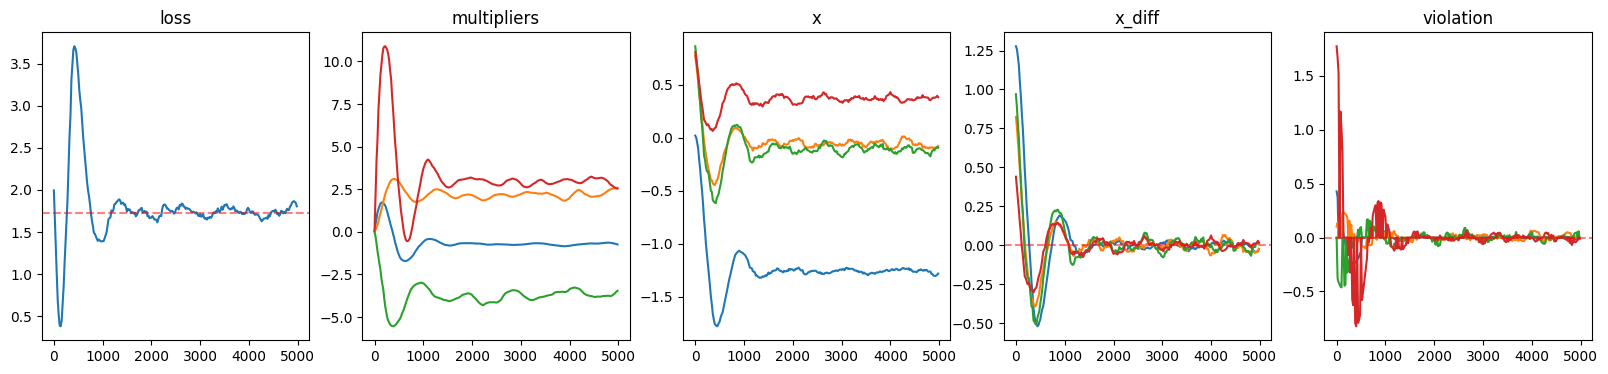

In [8]:
plot_results(state_history, x_optim.norm().item() ** 2)